### Career Satisfaction

In this notebook, I'm trying to find out top indicators (different variables which matters) for Career Satisfaction.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.describe()

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,19102.000000,16102.000000,15253.000000,7721.000000,13452.000000,5009.000000,818.000000
mean,9551.500000,7.343932,7.000721,3.685922,8.357865,58341.398571,32231.521687
std,5514.416757,1.919330,2.128648,7.330691,1.405546,40753.384986,28543.877274
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4776.250000,6.000000,6.000000,0.000000,8.000000,27956.989247,4716.459735
50%,9551.500000,8.000000,7.000000,1.000000,8.000000,51612.903226,29784.946237
75%,14326.750000,9.000000,8.000000,3.000000,9.000000,83333.333333,50000.000000
max,19102.000000,10.000000,10.000000,40.000000,10.000000,195000.000000,120000.000000


Although this dataset has 19102 records, question related to CareerSatisfaction has been answered only by 16102 respondants. Hence, for this particular analysis, I will drop the rows with missing CareerSatisfaction.

Since Respondant column is just like an index, will drop that too..

Further, ExpectedSalary column will also be dropped, because only 818 (4.28%) has responded to it.

But, for other **Quantitative variables**, I'm imputing with **mean of each column.

**One Hot Encoding** is used for **Categorical variables.**

In [4]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no Career Satisfaction
    2. Create X as all the columns that are not the CareerSatisfaction column
    3. Create y as the CareerSatisfaction column
    4. Drop the CareerSatisfaction, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    df = df.dropna(subset=['CareerSatisfaction'], axis=0)
    X = df.drop(labels='CareerSatisfaction', axis=1)
    y = df['CareerSatisfaction']
    
    X = X.drop(labels=['Respondent','ExpectedSalary'], axis=1)
    
    numeric_cols = X.select_dtypes(include=['int','float']).columns
    
    for col in numeric_cols:
        X[col].fillna(X[col].mean(), inplace=True)
    
    cat_cols = X.select_dtypes(include=['object']).columns
    
    for col in cat_cols:
        X = pd.concat([X.drop(col,axis=1),pd.get_dummies(X[col],prefix=col,prefix_sep='_',dummy_na=False,drop_first=True)],axis=1)
    
    return X, y
    
    
#Use the function to create X and y
X, y = clean_data(df)   

In [5]:
X.shape

(16102, 21306)

Using all of the 21306 variables will drastically overfit the training data. Hence, we will try to find the optimal model by trying out with different cutoff values.

In [6]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model and vice versa
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

In [7]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default True, to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

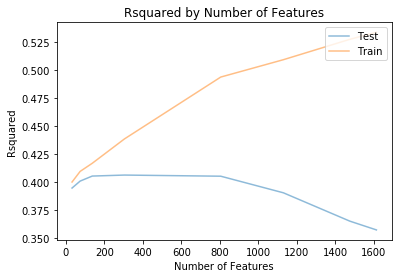

In [8]:
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [9]:
r2_scores_test

[0.3945223190161258,
 0.4007186553783617,
 0.40521115476278946,
 0.40609782221758906,
 0.4050818831371569,
 0.39027191131800365,
 0.3649703510550033,
 0.35713718669100614]

In [10]:
r2_scores_train

[0.39988999211421195,
 0.4093679327429901,
 0.4166318378276169,
 0.43835016386651793,
 0.4935901393015154,
 0.5090723023881971,
 0.527264497602565,
 0.533590455858793]

According rsquared values of test data, the maximum is 0.40609782221758906. It is recorded when cutoff is 1000 and number of features lies somewhere between 100 to 200.

The default penalty on coefficients using linear regression in sklearn is a ridge (also known as an L2) penalty. Because of this penalty, and that all the variables were normalized, we can look at the size of the coefficients in the model as an indication of the impact of each variable on the CareerSatisfaction. 

**The larger the coefficient, the larger the expected impact on CareerSatisfaction.**

In [11]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#look at the top 20 results
coef_df.head(20)

,est_int,coefs,abs_coefs
4,Professional_Professional developer,0.628331,0.628331
0,JobSatisfaction,0.519891,0.519891
189,DifficultCommunication_Strongly disagree,0.345434,0.345434
5,Professional_Professional non-developer who so...,0.304543,0.304543
15,"EmploymentStatus_Independent contractor, freel...",0.286303,0.286303
32,CompanyType_Publicly-traded corporation,0.252075,0.252075
10,Country_India,-0.246024,0.246024
77,KinshipDevelopers_Disagree,-0.240376,0.240376
119,AssessJobProduct_Not very important,-0.226778,0.226778
8,"ProgramHobby_Yes, both",0.218092,0.218092


In [12]:
df.DifficultCommunication.value_counts()

Disagree             5814
Somewhat agree       2349
Strongly disagree    1978
Agree                 885
Strongly agree        184
Name: DifficultCommunication, dtype: int64

In [13]:
df.Professional.value_counts()

Professional developer                                  13774
Student                                                  2821
Professional non-developer who sometimes writes code     1782
None of these                                             368
Used to be a professional developer                       357
Name: Professional, dtype: int64

According to the coefficients, **Professionalism** seems to have a high impact on CareerSatisfaction. Further, **JobSatisfaction** and **Communication Skills** also plays a vital role. 